### Recap from previous Lab

* We explored PyTorch (PT) tensor support and drew parallelisms w.r.t. NumPy `ndarray`
* We experimented with some basic Machine Learning (ML) building blocks in PT
* We built our first, very simple Artificial Neural Network (ANN), a MultiLayer Perceptron (MLP)

### Agenda for today

* Today we will be training a MLP using SGD and backpropagation
  * we will not be using the synthetic dataset we saw last lecture
  * we will be training our MLP on the MNIST dataset, which is a simple (in modern terms) dataset on which to train our ANNs. Due to this reputation, this problem is also called the *Hello World of Deep Learning*

### Intro to MNIST

MNIST is a dataset for **handwritten digit recognition**.

![](img/mnist.png)

* The dataset is composed of 60,000 grayscale images
  * by default, the dataset is already split into a training set of 50,000 images, while the remaining 10,000 images make up the test/validation set
* Each image is composed of 28x28 pixel
* Only one digit is present in each image
  * thus, we will be classifying digits from 0 to 9 (10 classes)
* The digit is centered within the image

#### Downloading the data

Since we're not covering the handling of data in this specific tutorial, I have prepared an external script which will download the data and "pack" it into DataLoaders.
You just need to know that DataLoaders and Datasets are two different entities; namely, DataLoaders are build on top of Datasets and handle the creation of the mini-batches that will later be fed into the MLP for the training and testing phase.

The script returns both the DataLoaders and Datasets, in case you wanna play with them

In [1]:
import torch
from scripts import mnist
from matplotlib import pyplot as plt

minibatch_size_train = 256
minibatch_size_test = 512

trainloader, testloader, trainset, testset = mnist.get_data(batch_size_train=minibatch_size_test, batch_size_test=minibatch_size_test)

Let us quickly view our data

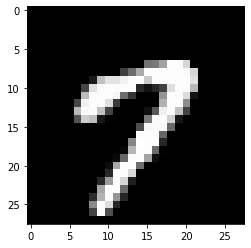

In [2]:
plt.imshow(trainset.data[15].numpy(), cmap="gray")

By applying the `Tensor` skills we learned during the previous lab, we may also plot multiple images within the same plot.


In [3]:
multi_img = trainset.data[25:30]
multi_img.shape

torch.Size([5, 28, 28])

We have a (5 x 28 x 28) `Tensor`, we can't plot it with `plt.imshow` because it needs a matrix as input.

**Q**: how can we solve this problem? Think about the methods we saw during the last lab

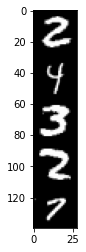

In [4]:
# solve here
# shape 5*28 x 28
multi_img_reshaped = multi_img.reshape(5*28, 28)
plt.imshow(multi_img_reshaped.numpy(), cmap="gray")

#### Designing our MLP

Let us design our MLP.

We need to think about:

1. How wide is the output layer?
2. How wide is the input layer and how is it structured?
3. How many hidden layers and how wide need they be?
4. What activation functions will we be using?

You may try answering questions 1 and 2 by yourself as there's only one specific answer.
Q. 3 and 4, instead, are a choice operated by the designer (the data scientist) and there is no straight definite answer, as usually architectural features are treated as hyperparameters to be tuned as part of the training process.

For our MLP, then, we will be designing an MLP with
* 3 hidden layers
  * the first hidden layer has 16 neurons
  * the second hidden layer has 32 neurons
  * the third hidden layer has 24 neurons
* ReLU as activation function for the hidden layers ($ReLU(x) = \max(0, x)$)
* Cross Entropy loss (or, equivalently, Negative LogLikelihood loss)

![](img/mlp_mnist.png)

In [5]:
# write here the class for your MLP
class MLP(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.flat = torch.nn.Flatten() # X comes in as a n x 1 x 28 x 28 -> we need n 784-size vectors (or, a n x 784 matrix). flatten does this
        self.layer1 = torch.nn.Linear(784, 16)
        self.layer2 = torch.nn.Linear(16, 32)
        self.layer3 = torch.nn.Linear(32, 24)
        self.layer4 = torch.nn.Linear(24, 10)

    def forward(self, X): 
        out = self.flat(X)
        out = self.layer1(out)
        out = torch.nn.functional.relu(out)
        out = self.layer2(out)
        out = torch.nn.functional.relu(out)
        out = self.layer3(out)
        out = torch.nn.functional.relu(out)
        out = self.layer4(out)
        # out = torch.nn.functional.softmax(out) -> this is wrong since we will use NegativeLogLikelihood Loss
        # softmax transforms a vector into a simplex (vector of positive nums summing to 1): 
        # [1,2,3,4] -> [0.1, 0.2, 0.3, 0.4]
        # instead we need the logsoftmax
        out = torch.nn.functional.log_softmax(out)
        return out

#### The training loop

We now have to train the network using mini-batch Stochastic Gradient Descent (which we'll indicate as SGD).

The mini-batch part is already handled by the `DataLoader`.

We just need to call


```python
for X, y in dataloader:
    # do something
```

`X` and `y` represent our mini-batch (images and ground truth respectively).

* What do we need to do inside this loop?
  1. do the forward pass
  2. calculate the loss
  3. do the backward pass and update the parameters
* What objects do we need inside this loop?
  * the model (to do the forward pass)
  * the dataloader (to get `X, y`)
  * the loss function (to calculate the value of the loss and backpropagate)
  * the optimizer (to upgrade the value of the parameters given the gradients obtained via backprop)
* What do we need to do outside this loop?
  1. re-shuffle the mini-batches (NB: already taken care of by the `DataLoader`)
  2. repeat the loop for each epoch

Next, we are going to implement this loop (which we'll call `train_epoch`) in a minimalistic setting, i.e., with no excessive feature or embellishment.
  



In [6]:
def train_epoch(model, dataloader, loss_fn, optimizer):
    for X, y in dataloader:
        # 1. reset the gradients previously accumulated by the optimizer
        #    this will avoid re-using gradients from previous loops
        optimizer.zero_grad() 
        # 2. get the predictions from the current state of the model
        #    this is the forward pass
        y_hat = model(X)
        # 3. calculate the loss on the current mini-batch
        loss = loss_fn(y_hat, y)
        # 4. execute the backward pass given the current loss
        loss.backward()
        # 5. update the value of the params
        optimizer.step()

#### Question: there's also a `model.zero_grad()` functionality. Is it the same as `optimizer.zero_grad()`?

Quick answer: usually yes. I have always seen `optimizer.zero_grad()` but some people prefer the former. See [here](https://discuss.pytorch.org/t/whats-the-difference-between-optimizer-zero-grad-vs-nn-module-zero-grad/59233) for discussion.

To work, we just need to wrap this routine inside another loop which will repeat `train_epoch` for each epoch.

In [7]:
def train_model(model, dataloader, loss_fn, optimizer, num_epochs):
    # this is a useful switch that lets us pass to training phase to network evaluation
    # we will see in a future lab why it is necessary - for now it does nothing in particular
    model.train()
    for epoch in range(num_epochs):
        train_epoch(model, dataloader, loss_fn, optimizer)
        print(f"Epoch {epoch+1} completed.") # this is just so we have an idea on where we are during the training

We will use vanilla SGD with a learning rate of 0.001 and we'll run the training for 3 epochs.
Moreover, we will use the Negative Log-Likelihood (NLL) loss function.

In [8]:
learn_rate = 0.1 # for SGD
num_epochs = 3

In [9]:
model = MLP()
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learn_rate)

In [10]:
train_model(model, trainloader, loss_fn, optimizer, num_epochs)

<ipython-input-5-80b9571ca551>:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
Epoch 1 completed.
Epoch 2 completed.
Epoch 3 completed.


The problem with this setting is that we have no idea how the network is faring, either on the training or the test set.

We need to devise some ways to assess the model.

Three ideas:

1. Accumulate the loss for each epoch
  * Alternatively, use the average loss per instance
2. Show the mean accuracy for each epoch
3. 1 and 2, but calculated on the test set

1 is easily implementable, just introduce a variable to accumulate the loss during the epoch and print it at the end of the training.

For 2 we need also to store the number of data points we have seen up to the current mini-batch. Recalling the concept of cumulative weighted average (CWA) for a time-dependent entity $x_t,~ t\in\{0,...,T\}$:

$\text{CWA}_t = \frac{ n_{0 : t-1} \cdot \text{CWA}_{t-1} + n_t \cdot x_t }{n_{0 : t-1} + n_t}$

where $n_t$ is the weight of the $t$-th observation $x_t$, while $n_{0 : t-1}$ is the cumulative weight of the observations from time instant $0$ to $t-1$.

In [11]:
def train_epoch(model, dataloader, loss_fn, optimizer, loss_cwa, cum_num_instances):
    for X, y in dataloader:
        # 1. reset the gradients previously accumulated by the optimizer
        #    this will avoid re-using gradients from previous loops
        optimizer.zero_grad() 
        # 2. get the predictions from the current state of the model
        #    this is the forward pass
        y_hat = model(X)
        # 3. calculate the loss on the current mini-batch
        loss = loss_fn(y_hat, y)
        # 4. execute the backward pass given the current loss
        loss.backward()
        # 5. update the value of the params
        optimizer.step()
        # 6. update the cumulative weighted average of the loss
        # a. obtain size of mini-batch
        current_n = X.shape[0]
        # b. update the CWA
        loss_cwa = (loss_cwa * cum_num_instances + loss.item() * current_n) / (cum_num_instances + current_n)
        # c. update the cumulative number of instances seen
        cum_num_instances += current_n

def train_model(model, dataloader, loss_fn, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        loss_cwa = 0.0
        cum_num_instances = 0
        train_epoch(model, dataloader, loss_fn, optimizer, loss_cwa, cum_num_instances)
        print(f"Epoch {epoch+1} completed. Cumulative average of training loss: {loss_cwa}")

Usually, though, since passing parameters like `loss_cwa` and `cum_num_instances` is a bit of a bloater, we usually employ a small class to keep track of all the performance parameter we need to measure. In the PT programming environment we call it `AverageMeter` and is implemented like so

In [12]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [13]:
def train_model(model, dataloader, loss_fn, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        loss_meter = AverageMeter() # zero out average meter -- we are only keeping track of performance through each epoch
        train_epoch(model, dataloader, loss_fn, optimizer, loss_meter)
        # now with loss meter we can print both the cumulative value and the average value
        print(f"Epoch {epoch+1} completed. Loss - total: {loss_meter.sum} - average: {loss_meter.avg}")


def train_epoch(model, dataloader, loss_fn, optimizer, loss_meter):
    for X, y in dataloader:
        # 1. reset the gradients previously accumulated by the optimizer
        #    this will avoid re-using gradients from previous loops
        optimizer.zero_grad() 
        # 2. get the predictions from the current state of the model
        #    this is the forward pass
        y_hat = model(X)
        # 3. calculate the loss on the current mini-batch
        loss = loss_fn(y_hat, y)
        # 4. execute the backward pass given the current loss
        loss.backward()
        # 5. update the value of the params
        optimizer.step()
        # 6. update the loss AverageMeter
        loss_meter.update(val=loss.item(), n=X.shape[0])




#### Assessing accuracy

Usually, $\text{loss} \in [0;+\infty)$, so it is hard to assess the effectiveness of the ANN based solely on such value.

Alongside a loss, we can assess the performance via a much more interpretable index as the **accuracy**

$\text{accuracy} = \frac{\text{# correctly identified items}}{\text{# all items}}$

To keep track of the accuracy, we can re-use the AverageMeter defined above, although we need to define a function for it---since PT does not implement it by default.

In [14]:
def accuracy(y_hat, y):
    '''
    y_hat is the model output - a Tensor of shape (n x num_classes)
    y is the ground truth

    How can we implement this function?
    '''
    classes_prediction = y_hat.argmax(dim=1)
    match_ground_truth = classes_prediction == y # -> tensor of booleans
    correct_matches = match_ground_truth.sum()
    return (correct_matches / y_hat.shape[0]).item()
    

In [15]:
def train_epoch(model, dataloader, loss_fn, optimizer, loss_meter, accuracy_meter):
    for X, y in dataloader:
        # 1. reset the gradients previously accumulated by the optimizer
        #    this will avoid re-using gradients from previous loops
        optimizer.zero_grad()
        # 2. get the predictions from the current state of the model
        #    this is the forward pass
        y_hat = model(X)
        # 3. calculate the loss on the current mini-batch
        loss = loss_fn(y_hat, y)
        # 4. execute the backward pass given the current loss
        loss.backward()
        # 5. update the value of the params
        optimizer.step()
        # 6. calculate the accuracy for this mini-batch
        acc = accuracy(y_hat, y)
        # 7. update the loss and accuracy AverageMeter
        loss_meter.update(val=loss.item(), n=X.shape[0])
        accuracy_meter.update(val=acc, n=X.shape[0])

def train_model(model, dataloader, loss_fn, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        loss_meter = AverageMeter()
        accuracy_meter = AverageMeter()
        train_epoch(model, dataloader, loss_fn, optimizer, loss_meter, accuracy_meter)
        # now with loss meter we can print both the cumulative value and the average value
        print(f"Epoch {epoch+1} completed. Loss - total: {loss_meter.sum} - average: {loss_meter.avg}; Accuracy: {accuracy_meter.avg}")
    # we also return the stats for the final epoch of training
    return loss_meter.sum, accuracy_meter.avg

*Additional observation*: we might wanna pass the `accuracy` as an additional `performance` parameter (analogous to `loss_fn`) since we might wanna evaluate the performance on a metric different than accuracy.

Now, we can train the network and examine its performance as we're running the training

In [16]:
# reset the network and optimizer
model = MLP()
optimizer = torch.optim.SGD(model.parameters(), lr=learn_rate)

loss, acc = train_model(model, trainloader, loss_fn, optimizer, num_epochs)
print(f"Training completed - final accuracy {acc} and loss {loss}")

<ipython-input-5-80b9571ca551>:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
Epoch 1 completed. Loss - total: 89184.51410484314 - average: 1.4864085684140522; Accuracy: 0.5081666666666667
Epoch 2 completed. Loss - total: 27751.31996536255 - average: 0.46252199942270916; Accuracy: 0.8585166666348775
Epoch 3 completed. Loss - total: 20395.6908493042 - average: 0.33992818082173665; Accuracy: 0.8997333333333334
Training completed - final accuracy 0.8997333333333334 and loss 20395.6908493042


Recall that we wanted to assess also the network's performance on the test set. We need an additional testing routine for it.

For testing, we need only

1. the network
2. the test-set `DataLoader`
3. the loss function / the performance metrics

we don't need the optimizer as we're not updating the weights now


In [17]:
def test_model(model, dataloader, loss_fn=None):
    if loss_fn is not None:
        loss_meter = AverageMeter()
    acc_meter = AverageMeter()
    model.eval() # this is the contrary of model.train() we saw before - equivalent to model.train(False)
    with torch.no_grad():
        for X, y in dataloader:
            y_hat = model(X)
            loss = loss_fn(y_hat, y) if loss_fn is not None else None
            acc = accuracy(y_hat, y)
            if loss_fn is not None:
                loss_meter.update(loss.item(), X.shape[0])
            acc_meter.update(acc, X.shape[0])
    print(f"TESTING - loss {loss_meter.sum if loss_fn is not None else '--'} - accuracy {acc_meter.avg}")


In [18]:
test_model(model, testloader)

<ipython-input-5-80b9571ca551>:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
TESTING - loss -- - accuracy 0.8916000000317892


Now that we have nice-enough-looking training and testing routines and that we have trained and tested our model we might want to save it so we can re-use it in the future.

The model can be easily saved using the `state_dict()` method

We can save it using PT built-in `torch.save`

In [19]:
import os
folder_save = "models/mlp_mnist"
os.makedirs(folder_save, exist_ok=True)
filename = os.path.join(folder_save, "model.pt")
torch.save(model.state_dict(), filename)

Let's suppose we wish to reload the state_dict. We just need one line of code: 

In [20]:
model.load_state_dict(torch.load(filename))

<All keys matched successfully>

# --- LAB ended here ---

#### Saving a model mid-training

Let's suppose we further need to train our model. Often times, storing only the weights may not be enough.

Till now, we have only seen examples in which the training hyperparameters are static. Modern techniques, though, require dynamic hyperparameters to ensure good performance or generalization. You may have heard of optimizers such as ADAM or techniques such as learning rate annealing. Thus, in order to restore the training, we need to save a **checkpoint** so that we're able to re-start training at the exact same conditions we were in when it first ended^.

For now, a checkpoint will be composed of the following objects:
1. The `state_dict` of the model
2. The state of the optimizer (which is also obtainable via a `state_dict` method---see code)
3. (*optionally*) the epochs trained


^ *Note that, due to the stochasticity intrinsic in SGD, we may not actually be able to reproduce the exact same situation as before.*

In [ ]:
checkpoint_dict = {
    "parameters": model.state_dict(),
    "optimizer": optimizer.state_dict(),
    "epoch": num_epochs
}

In [ ]:
# save
filename = os.path.join(folder_save, "checkpoint.pt")
torch.save(checkpoint_dict, filename)

In [ ]:
# restore checkpoint
checkpoint = torch.load(filename)
model.load_state_dict(checkpoint["parameters"])
optimizer.load_state_dict(checkpoint["optimizer"])

In a setting where you wish to restart training, you may modify the `train_model` function by adding the argument `epoch_restart` and looping through epochs like this
```python
for epoch in range(epoch_restart, num_epochs):
    # train loop
```

**Tip**: especially when training large networks in clusters (where time allocated may be limited) it may be savvy to save a checkpoint at each epoch or training iteration to avoid repeating large chunks of training in case the job hangs up.

#### Training a model on custom loss functions

We might want to fit our MLP using custom losses. Despite being the *de facto* choice for multiclass ML problems, Cross Entropy is not the single loss we can use.

A very simple loss we may consider is the Quadratic Loss (QL) [1](https://www.semanticscholar.org/paper/Exploring-the-Role-of-Loss-Functions-in-Multiclass-Demirkaya-Chen/5c80d4ce2ce5e4f0b395969618cd76d35210e72c):

$QL(\hat{y}, y) = \frac{1}{2}\text{E}[\vert\vert y^{(\text{one-hot})} - \hat{y} \vert\vert^2] 
 = \frac{1}{2n}\sum_{i=1}^{n} (\vert\vert y^{(\text{one-hot})}_i - \hat{y}_i \vert\vert)^2
 = \frac{1}{2n}\sum_{i=1}^{n}\sum_{j=1}^{d}(y^{(\text{one-hot})}_{i,j} - \hat{y}_{i,j})^2$

Where:
* the one-hot encoding for $y=c$, where $c$ is a possible class out of $C$ classes, is the column vector whose elements are all $0$ beside the $c$-th entry, which is $1$;
* with $\hat{y}$ we mean the output of the model, i.e. a vector representing a probability distribution that a data point be assigned to each class.

For instance, given a data point whose ANN output is $\hat{y}=[0.3, 0.2, 0.4, 0.1]^\top$ and the ground truth is $y=3$, the QL for this point is

$0.5\cdot \vert\vert[0, 0, 1, 0]^\top - [0.3, 0.2, 0.4, 0.1]^\top\vert\vert^2 = 0.5\cdot \vert\vert[-0.3, -0.2, 0.6, -0.1]^\top\vert\vert^2
= 0.5\cdot (0.09 + 0.04 + 0.36 + 0.01) = 0.5\cdot 0.5 = 0.25$

Let us implement this loss function in PT

In [ ]:
def quadratic_loss(y_hat, y):
    '''
    y_hat is a matrix of dimension (C x n),
    where C is the number of classes, and n is the number of datapoints
    y is a vector of classes
    '''
    # convert y to onehot
    y_onehot = torch.nn.functional.one_hot(y.long())
    norm = (y_onehot - y_hat.exp()).norm(dim=0)**2
    norm_sum = norm.sum()
    return norm_sum / (2*y_hat.shape[1])

In [ ]:
learn_rate = 0.1
num_epochs = 3

model = MLP()
loss_fn = quadratic_loss
optimizer = torch.optim.SGD(model.parameters(), lr=learn_rate)

In [ ]:
train_model(model, trainloader, loss_fn, optimizer, num_epochs)

**Q**: how were we able to train the network on our custom loss even if we never told PT how to compute the backward pass on it (i.e., how to compute its gradient)?

### Extra: Build ANNs with Sequential

Instead of specifying layers as attribute of the MLP, we may just create a single module which is an instance of `torch.nn.Sequential`:

In [ ]:
class MLP_seq(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(784, 64),
            torch.nn.ReLU(), # Note: you must use torch.nn.ReLU() here, not torch.nn.functional.relu
            torch.nn.Linear(64,64),
            torch.nn.ReLU(),
            torch.nn.Linear(64,10),
            torch.nn.LogSoftmax(dim=1)
        )
    
    def forward(self, X):
        return self.layers(X)

In `Sequential` we specify all the modules through which the data is sequentially fed (also the activation functions!).
PyTorch automatically creates a `forward` routine for that module. We just need to call `sequenial_module(data)` in the `forward` method of our network. 

Without training it, let's verify that it's equivalent to our original `MLP` module

In [ ]:
X, y = next(iter(trainloader))
first_5_images = X[:5]
print(first_5_images.shape)
model_seq = MLP_seq()
output = model_seq(first_5_images)
print(output.shape)
print(output[0].exp().sum())

Delving into the difference between
* `torch.nn.functional.relu()` and
* `torch.nn.ReLU()`

notice how they're used.
* `torch.nn.functional.relu(X)` expects an argument `X`
* `torch.nn.ReLU()` expects no argument

Indeed, `torch.nn.functional.relu(X)` is a function, while `torch.nn.ReLU()` is a "functional representation" of the former.

`torch.nn.ReLU()`, though, is a bit more than that.

### Custom activation functions

Let us suppose we wish to add a custom activation function to our network, for example, the sine function.

We'll quickly discover that we can't just add a functional representation of it to our `Sequential`. Let's try it

In [ ]:
class SineNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.structure = torch.nn.Sequential(
            torch.nn.Linear(2, 2),
            torch.sin # this won't work!
        )
    
    def forward(self, X):
        return self.structure(X)

nn = SineNN()

In fact, PyTorch is complaining that the sin module is not inheriting from `torch.nn.Module`, which it needs to do. So, we only need to wrap `torch.sin` in a class like so.

In [ ]:
class Sin(torch.nn.Module):
    # it needs to have at least a constructor and a forward method, just like an MLP
    def __init__(self): 
        super().__init__()
        # no additional stuff to do here as Sin has no additional parameters to set
    
    def forward(self, X):
        return torch.sin(X)

In [ ]:
# it will not produce an exeption now
class SineNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.structure = torch.nn.Sequential(
            torch.nn.Linear(2, 2),
            Sin()
        )
    
    def forward(self, X):
        return self.structure(X)

nn = SineNN()

**Homework**

- ~~try reading [1] and implement Correct-Class Quadratic Loss (CCQL). Don't despair if you don't understand everything, just try grasping the concept and understanding the forumulation of CCQL.~~
- Reconstruct in PyTorch the first experiment in [Learning representations by back-propagating errors](https://www.nature.com/articles/323533a0) with learning rule in eq.8 (gradient descent without momentum)
  - Try to be as close as possible to the original protocol, except for what regards the learning rule
  - Read the paper, if you did not do it yet (don’t worry if you don’t understand the other experiments in detail)
  - Create the data, the model and everything is needed (do not use dataloaders if you don’t know how yet how they work)
  - Train the model
  - Inspect the weights you obtained and check if they provide a solution to the problem
  - Compare the solution to the solution reported in the paper


Additional tips for implementing ANNs in PyTorch (will not be part of the exam): [PyTorch common mistakes, by Aladdin Person](https://youtu.be/O2wJ3tkc-TU)

## References
[1](https://www.semanticscholar.org/paper/Exploring-the-Role-of-Loss-Functions-in-Multiclass-Demirkaya-Chen/5c80d4ce2ce5e4f0b395969618cd76d35210e72c) A. Demirkaya, J. Chen and S. Oymak, "Exploring the Role of Loss Functions in Multiclass Classification," 2020 54th Annual Conference on Information Sciences and Systems (CISS), Princeton, NJ, USA, 2020, pp. 1-5, doi: 10.1109/CISS48834.2020.1570627167.